<a href="https://colab.research.google.com/github/Ajjme/Bayesian-Flood-depth-damage-/blob/main/Bayesian_depth_damage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

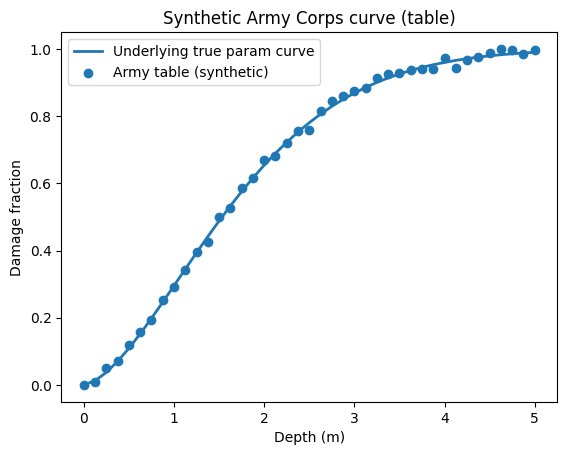

Total observations: 621
Observations per state (sample):
state
State_4    114
State_5    114
State_8    107
State_7    101
State_2     79
dtype: int64


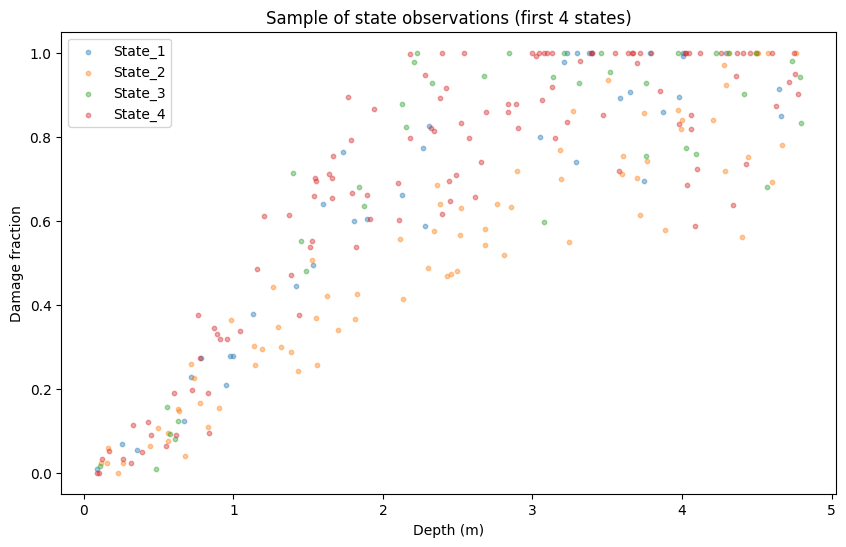

Fitted Army Corps parameters: alpha = 0.3502 ± 0.0044, beta = 1.6088 ± 0.0154


Output()

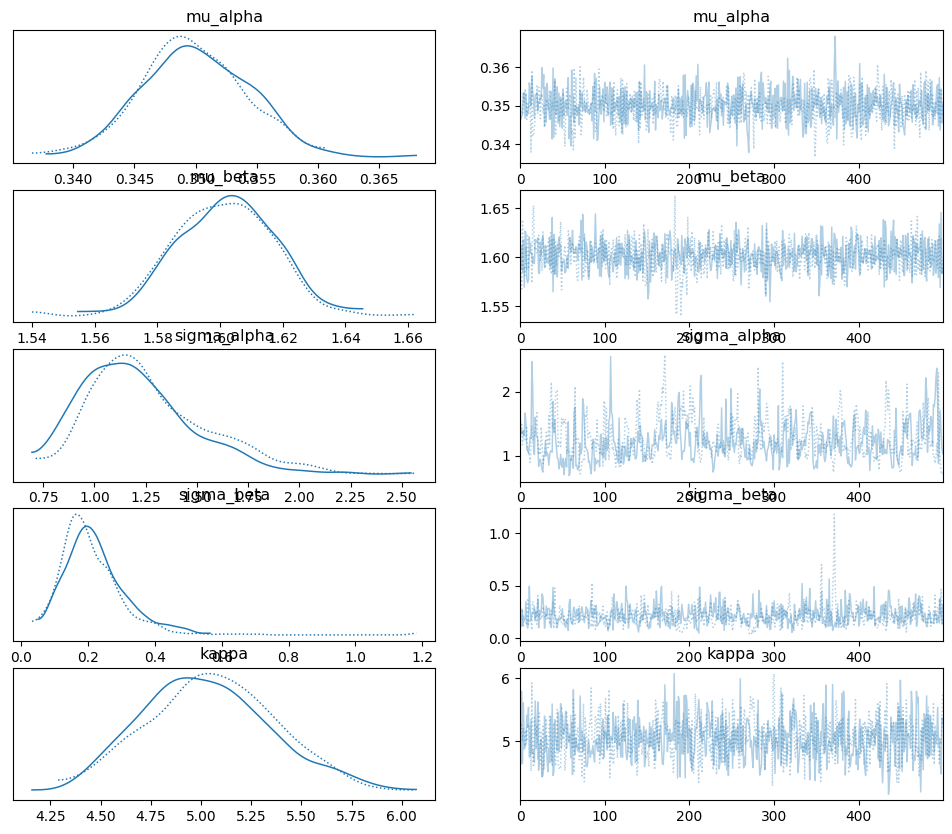

Output()

             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_alpha     0.35  0.00    0.34     0.36       0.00     0.00   1407.88   
mu_beta      1.60  0.02    1.57     1.63       0.00     0.00   1200.88   
sigma_alpha  1.25  0.31    0.74     1.81       0.02     0.01    256.77   
sigma_beta   0.22  0.09    0.06     0.39       0.00     0.01    441.10   
kappa        5.05  0.33    4.45     5.66       0.01     0.01    997.91   

             ess_tail  r_hat  
mu_alpha       682.48   1.00  
mu_beta        657.18   1.00  
sigma_alpha    372.37   1.01  
sigma_beta     289.51   1.01  
kappa          879.00   1.00  


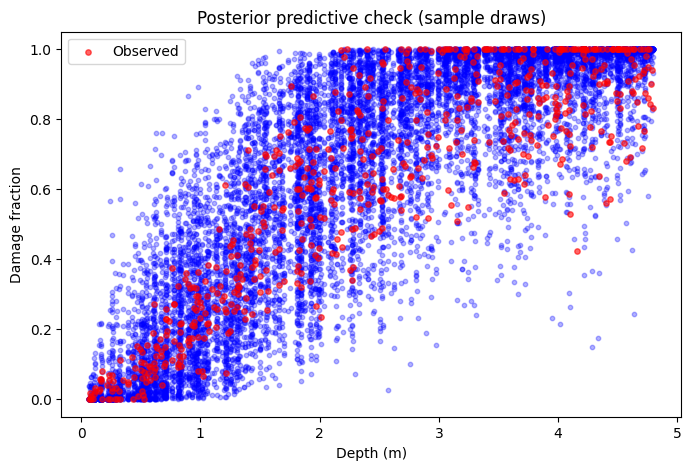

/tmp/ipython-input-478882535.py:229: RuntimeWarning: divide by zero encountered in power
  preds = 1 - np.exp(-np.outer(a_s, depth_grid**1.0) * (depth_grid**(b_s.reshape(-1,1)-1.0)))
/tmp/ipython-input-478882535.py:229: RuntimeWarning: invalid value encountered in multiply
  preds = 1 - np.exp(-np.outer(a_s, depth_grid**1.0) * (depth_grid**(b_s.reshape(-1,1)-1.0)))


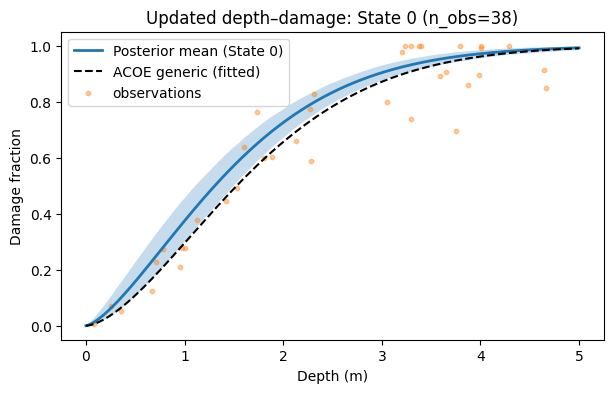

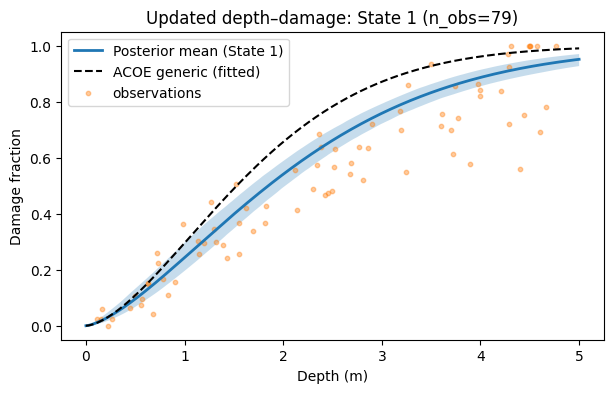

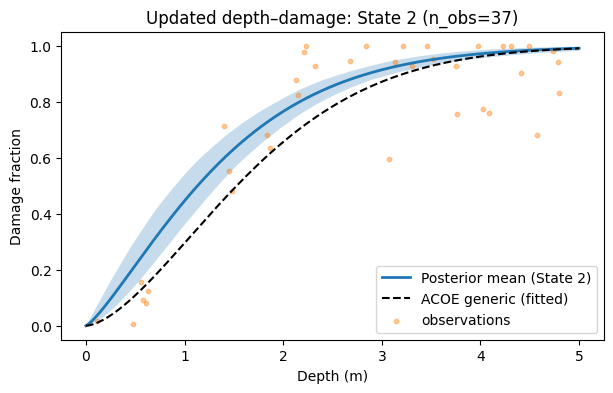

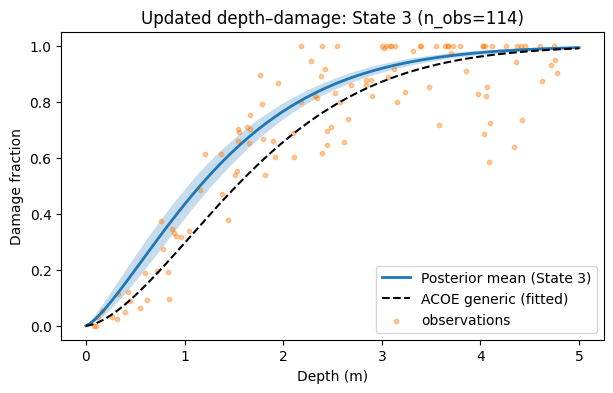

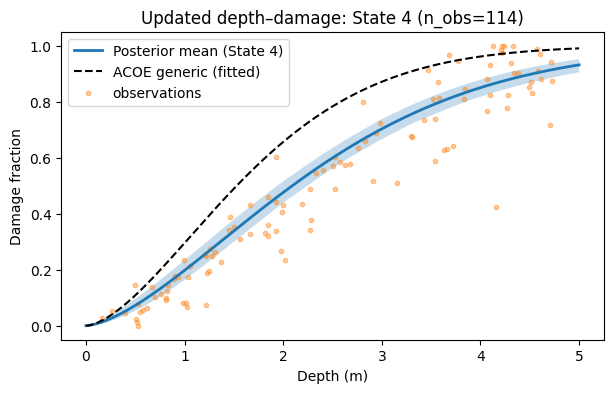

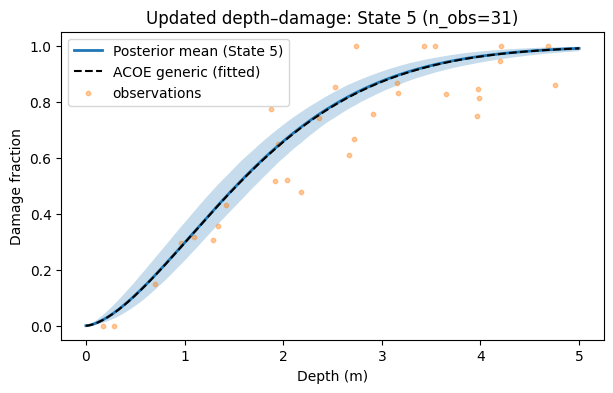

In [2]:
# Bayesian depth-damage example
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pymc as pm
import arviz as az
import pytensor.tensor as pt

# -------------------------
# 1) define parametric form
# -------------------------
def curve(depth, alpha, beta):
    return 1 - np.exp(-alpha * np.power(depth, beta))



# -------------------------
# 2) synthetic Army Corps "table"
# -------------------------
alpha_ac_true = 0.35
beta_ac_true  = 1.6
depth_grid_ac = np.linspace(0, 5.0, 41)
rng = np.random.default_rng(123)
damage_ac_true = curve(depth_grid_ac, alpha_ac_true, beta_ac_true)
# add tiny noise to simulate tabulated empirical curve
damage_ac_table = np.clip(damage_ac_true + rng.normal(scale=0.01, size=damage_ac_true.shape), 0, 1)
army_df = pd.DataFrame({'depth': depth_grid_ac, 'damage_frac': damage_ac_table})
depth_acoe = army_df["depth"].values
damage_acoe = army_df["damage_frac"].values

popt, pcov = curve_fit(curve, depth_acoe, damage_acoe, bounds=(0, np.inf))
alpha_ac, beta_ac = popt
alpha_sd, beta_sd = np.sqrt(np.diag(pcov))

# quick plot
plt.figure()
plt.plot(depth_grid_ac, damage_ac_true, label='Underlying true param curve', lw=2)
plt.scatter(army_df['depth'], army_df['damage_frac'], label='Army table (synthetic)', zorder=3)
plt.xlabel('Depth (m)')
plt.ylabel('Damage fraction')
plt.legend()
plt.title('Synthetic Army Corps curve (table)')
plt.show()

# -------------------------
# 3) synthetic state observations
# -------------------------
n_states = 8
state_names = [f"State_{i+1}" for i in range(n_states)]
rng = np.random.default_rng(42)

# true state-specific parameters (unknown to model)
alpha_state_true = alpha_ac_true * (1 + rng.normal(0.0, 0.25, size=n_states))
beta_state_true  = beta_ac_true  * (1 + rng.normal(0.0, 0.15, size=n_states))

rows = []
for s_idx, s in enumerate(state_names):
    n_obs = rng.integers(30, 120)  # variable sample size per state
    depths = rng.uniform(0.05, 4.8, size=n_obs)
    mu = curve(depths, alpha_state_true[s_idx], beta_state_true[s_idx])
    # heteroskedastic noise (bigger absolute noise for larger damage)
    obs_noise = rng.normal(scale=0.04 + 0.12 * mu, size=n_obs)
    y = np.clip(mu + obs_noise, 0.0, 1.0)
    # small chance of underreporting tiny damages
    under_report_mask = (rng.random(n_obs) < 0.03) & (y < 0.15)
    y[under_report_mask] = y[under_report_mask] * rng.uniform(0.1, 0.4, size=under_report_mask.sum())
    for di, yi in zip(depths, y):
        rows.append({'state': s, 'depth': di, 'damage_frac': yi})

state_df = pd.DataFrame(rows)
state_df['state_id'] = state_df['state'].astype('category').cat.codes

#new # --- ensure army table has no exact 0/1 (you already clipped a little earlier, but be safe)
army_df['damage_frac'] = army_df['damage_frac'].clip(1e-6, 1 - 1e-6)

# --- ensure observed data are strictly inside (0,1) to be valid for Beta likelihood
state_df['damage_frac'] = state_df['damage_frac'].clip(1e-6, 1 - 1e-6)

# quick sanity check (helpful if you get the same error again)
if not np.isfinite(state_df['damage_frac']).all():
    raise ValueError("Non-finite damage_frac present")
if ((state_df['damage_frac'] <= 0).any() or (state_df['damage_frac'] >= 1).any()):
    print("Warning: some damage_frac are exactly 0 or 1; they've been clipped.")
print("Total observations:", len(state_df))
print("Observations per state (sample):")
print(state_df.groupby('state').size().sort_values(ascending=False).head())

# plot sample states
plt.figure(figsize=(10,6))
for s in state_names[:4]:
    dsub = state_df[state_df['state'] == s]
    plt.scatter(dsub['depth'], dsub['damage_frac'], s=10, alpha=0.4, label=s)
plt.xlabel('Depth (m)')
plt.ylabel('Damage fraction')
plt.legend()
plt.title('Sample of state observations (first 4 states)')
plt.show()

# -------------------------
# 4) fit Army Corps curve to get priors
# -------------------------
popt, pcov = curve_fit(curve, army_df['depth'].values, army_df['damage_frac'].values, bounds=(0, np.inf))
alpha_ac_fit, beta_ac_fit = popt
alpha_ac_sd, beta_ac_sd = np.sqrt(np.diag(pcov))
print(f'Fitted Army Corps parameters: alpha = {alpha_ac_fit:.4f} ± {alpha_ac_sd:.4f}, beta = {beta_ac_fit:.4f} ± {beta_ac_sd:.4f}')

# -------------------------
# 5) build hierarchical PyMC model
# -------------------------
d = state_df['depth'].values
y = state_df['damage_frac'].values
state_ids = state_df['state_id'].values
n_states = state_df['state_id'].nunique()

# inflate the fitted SDs a bit to avoid overconfident priors
alpha_prior_sd = max(alpha_ac_sd * 3, 0.5 * alpha_ac_fit)
beta_prior_sd  = max(beta_ac_sd * 3, 0.2 * abs(beta_ac_fit))

with pm.Model() as model:

    # Hyperpriors centered on generic ACOE values
    mu_alpha = pm.Normal("mu_alpha", mu=alpha_ac, sigma=alpha_sd)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1.0)

    mu_beta = pm.Normal("mu_beta", mu=beta_ac, sigma=beta_sd)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=1.0)

    # State-level alpha (must be positive)
    raw_alpha = pm.Normal("raw_alpha", mu=0, sigma=1, shape=n_states)
    alpha_state = pm.Deterministic(
        "alpha_state",
        pt.softplus(mu_alpha + raw_alpha * sigma_alpha)
    )

    # State-level beta (shape parameter)
    beta_state = pm.Normal("beta_state", mu=mu_beta, sigma=sigma_beta, shape=n_states)

    # Dispersion parameter for Beta likelihood
    kappa = pm.Exponential("kappa", lam=1.0)

    # Compute mean damage safely
    depth_pow = pt.power(d, beta_state[state_ids])      # safe exponentiation
    arg = -alpha_state[state_ids] * depth_pow
    arg = pt.clip(arg, -50, 50)                         # prevent overflow

    mu = 1 - pt.exp(arg)
    mu = pt.clip(mu, 1e-6, 1 - 1e-6)                    # keep in (0,1)

    # Likelihood
    pm.Beta("y_obs",
            alpha=mu * kappa,
            beta=(1 - mu) * kappa,
            observed=y)

    trace = pm.sample(
    tune=500,      # fewer tuning steps
    draws=500,     # fewer posterior draws
    chains=2,      # default is usually 4; fewer chains = faster
    target_accept=0.9,
    random_seed=123
)

# -------------------------
# 6) posterior diagnostics & summary
# -------------------------
az.plot_trace(trace, var_names=['mu_alpha', 'mu_beta', 'sigma_alpha', 'sigma_beta', 'kappa'])
plt.show()

print(az.summary(trace, var_names=['mu_alpha', 'mu_beta', 'sigma_alpha', 'sigma_beta', 'kappa'], round_to=2))

# -------------------------
# 7) posterior-predictive checks (manual plotting)
# -------------------------
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=123)

# The result is an xarray DataArray with shape (chain, draw, n_observations)
# Example shape: (2, 500, 700) -> 2 chains, 500 draws, 700 observations
ppc_samples_xarray = ppc.posterior_predictive['y_obs']
ppc_samples = ppc_samples_xarray.values

# Calculate the total number of samples (population size for choice)
chains = ppc_samples.shape[0]
draws = ppc_samples.shape[1]
n_total_samples = chains * draws

# Reshape the array to (n_total_samples, n_observations)
ppc_samples_flat = ppc_samples.reshape(n_total_samples, -1)

# --- Your original code resumes here, using the flattened array ---
# ppc_samples_flat has shape (1000, N_observations)

# pick a few random posterior predictive draws to plot
n_plot = 20
# Now the population size is ppc_samples_flat.shape[0] = 1000, which is > 20.
idx = np.random.choice(ppc_samples_flat.shape[0], n_plot, replace=False)

plt.figure(figsize=(8,5))
for i in idx:
    plt.scatter(state_df['depth'], ppc_samples_flat[i], s=10, alpha=0.3, color='blue')
# overlay observed data
plt.scatter(state_df['depth'], state_df['damage_frac'], s=15, alpha=0.6, color='red', label='Observed')
plt.xlabel('Depth (m)')
plt.ylabel('Damage fraction')
plt.title('Posterior predictive check (sample draws)')
plt.legend()
plt.show()


# -------------------------
# 8) compute updated curves per state
# -------------------------
# get flattened posterior samples for state-level params
posterior = trace.posterior  # xarray dataset, dims: chain, draw, [state dim]
# reshape to (n_samples, n_states)
chains, draws = posterior.sizes['chain'], posterior.sizes['draw']
n_samples = chains * draws
alpha_samples = posterior['alpha_state'].values.reshape(n_samples, n_states)
beta_samples  = posterior['beta_state'].values.reshape(n_samples, n_states)

depth_grid = np.linspace(0, 5.0, 200)
summary_curves = {}

for s in range(n_states):
    a_s = alpha_samples[:, s]   # shape (n_samples,)
    b_s = beta_samples[:, s]    # shape (n_samples,)
    # compute preds for all posterior samples: shape (n_samples, len(depth_grid))
    preds = 1 - np.exp(-np.outer(a_s, depth_grid**1.0) * (depth_grid**(b_s.reshape(-1,1)-1.0)))
    # simpler correct computation
    # preds = 1 - np.exp(-a_s[:,None] * depth_grid[None,:]**b_s[:,None])
    # the above two approaches are equivalent; using direct broadcasting below:
    preds = 1 - np.exp(-a_s[:, None] * (depth_grid[None, :] ** b_s[:, None]))
    mean_curve = preds.mean(axis=0)
    lo = np.percentile(preds, 2.5, axis=0)
    hi = np.percentile(preds, 97.5, axis=0)
    summary_curves[s] = {'mean': mean_curve, 'lo': lo, 'hi': hi}

# -------------------------
# 9) plot a few states vs Army generic
# -------------------------
for s in range(min(6, n_states)):
    plt.figure(figsize=(7,4))
    plt.plot(depth_grid, summary_curves[s]['mean'], label=f'Posterior mean (State {s})', lw=2)
    plt.fill_between(depth_grid, summary_curves[s]['lo'], summary_curves[s]['hi'], alpha=0.25)
    plt.plot(depth_grid, curve(depth_grid, alpha_ac_fit, beta_ac_fit), '--', label='ACOE generic (fitted)', color='k')
    # overlay observed points for that state
    mask = state_df['state_id'] == s
    plt.scatter(state_df.loc[mask, 'depth'], state_df.loc[mask, 'damage_frac'], s=10, alpha=0.4, label='observations')
    plt.xlabel('Depth (m)')
    plt.ylabel('Damage fraction')
    plt.title(f'Updated depth–damage: State {s} (n_obs={mask.sum()})')
    plt.legend()
    plt.show()

# -------------------------
# 10) Save results
# -------------------------
# army_df.to_csv('army_corps_synthetic_curve.csv', index=False)
# state_df.to_csv('state_synthetic_observations.csv', index=False)
# print("Saved synthetic CSVs: army_corps_synthetic_curve.csv, state_synthetic_observations.csv")
